# qtpg

### imports

In [69]:
import numpy as np
import random
import time
from IPython.display import clear_output

### Downing fig 11 GridWorld 

#### GridWorld is based on fig 11 from Downing's "Reinforced Genetic Programming" paper
#### As shown below, it is a 5x5 maze
![DowningFig11](downing_fig_11.png)
#### The current implementation involves the following rewards per action:
#####  +100 to score upon reaching the goal
#####  -0.01 to score per action
#####  -1 to score upon repeating a state that was repeated n amount of times (n currently is 20)
#####  -1 to score upon hitting a wall or going out of bounds

In [70]:
# will use Downing fig 11 for testing on this
class GridWorld:
    def __init__ (self, rows, cols, win_state, start_state):
        self.memory = []
        self.memory_position = 0
        self.memory_limit = 20
        self.rows = rows
        self.cols = cols
        self.start_state = start_state
        self.win_state = win_state
        self.current_state = self.start_state
        
    def sample_action (self):
        rand = random.uniform(0, 1)
        if (rand >= 0) and (rand < 0.25):
            return 0
        elif (rand >= 0.25) and (rand < 0.5):
            return 1
        elif (rand >= 0.5) and (rand < 0.75):
            return 2
        else:
            return 3
        
    def reset (self):
        self.current_state = self.start_state
        return self.current_state
        
    # just reset for now...
    def close (self):
        self.current_state = self.start_state
        return 1
    
    def check_win (self):
        if self.current_state == self.win_state:
            return True
        return False
    
    def step (self, action):
        # north
        if action == 0:
            next = (self.current_state[0] - 1, self.current_state[1])
        # south
        elif action == 1:
            next = (self.current_state[0] + 1, self.current_state[1])
        # east
        elif action == 2:
            next = (self.current_state[0], self.current_state[1] + 1)
        # west
        else:
            next = (self.current_state[0], self.current_state[1] - 1)

        terminate = False
        reward = 0
        # check if move is legal
        if (next[0] >= 0 and next[0] <= (self.rows-1)) and (next[1] >= 0 and next[1] <= (self.cols-1)):            
            illegal = 0
            if (next == (1, 2)) or (next == (1, 3)) or (next == (2, 2)) or (next == (2, 3)):
                illegal = 1
                    
            if (illegal == 0):
                self.current_state = next
                reward += 0.01
                #reward -= 0.01
            else:
                #reward -= 1
                reward = reward
        else:
            #reward -= 1
            reward = reward
            
        # punish repeat states within last 20 states
        if self.current_state in self.memory:
            #reward -= 1
            reward = reward
        
        if self.check_win():
            reward += 100
            terminate = True
        
        # add new state to memory
        if len(self.memory) <= self.memory_limit:
            (self.memory).append(self.current_state)
        # after memory is full, begin overriding it
        else:
            if self.memory_position < self.memory_limit:
                self.memory[self.memory_position] = self.current_state
                self.memory_position += 1
            else:
                self.memory_position = 0
                self.memory[self.memory_position] = self.current_state
        
        return self.current_state, reward, terminate

### Reinforcement Learning Functions

In [71]:
class q_table: 
    def __init__ (self):
        self.q = []
    
    def create (self, agents):
        for agent in agents:
            team = agent.team
            for learner in team.learners:
                (self.q).append({'team': str(team.id), 'learner': str(learner.id), 
                                 'action': learner.actionObj.actionCode, 'q': 0})
    
    # add new learners upon evolution
    def evolve (self, agents):
        for agent in agents:
            team = agent.team
            # add new learners
            for learner in team.learners:
                found = 0
                for entry in self.q:
                    if (str(team.id) == entry['team']) and (str(learner.id) == entry['learner']) and (learner.actionObj.actionCode == entry['action']):
                        found = 1
                if found == 0:
                    (self.q).append({'team': str(team.id), 'learner': str(learner.id), 'action': learner.actionObj.actionCode, 'q': 0})
                        
    # remove old learners after evolution
    def clean (self, agents):
        for agent in agents:
            team = agent.team
            # if entry is not in the team, remove entry from q table
            for i in range(len(self.q)):
                if (self.q[i])['team'] == str(team.id):
                    found = 0
                    for learner in team.learners:
                        if  ((self.q[i])['learner'] == str(learner.id)) and ((self.q[i])['action'] == learner.actionObj.actionCode):
                            found = 1
                    if found == 0:
                        print('removing: ' + (self.q[i])['team'])
                        (self.q).pop(i)
                
    def update (self, team_id, learner_id, action, q_value):
        (self.q).append({'team': str(team_id), 'learner': str(learner_id), 'action': action, 'q': q_value})
    
    def display (self):
        for entry in self.q:
            print(entry)

In [72]:
def get_learners (team):
    print('Getting learners for team: ' + str(team.id))
    return team.learners

In [73]:
def evaluate (team, state, epsilon, q_table):
    #learners = get_learners(team)
    #top_bid = 0
    top_learner = None
    action = None   

    # get best learner
    actVars = {'frameNum':random.randrange(0, 100000000)}
    valid_learners = [lrnr for lrnr in team.learners if lrnr.isActionAtomic()]
    top_learner = max(valid_learners, key=lambda lrnr: lrnr.bid(state, actVars=actVars))

#     for learner in learners:
#         bid = learner.bid(state)
#         if (bid > top_bid):
#             top_bid = bid
#             top_learner = learner 

    if top_learner == None:
        print('No top learner found!')
        return None, 0
    else:
        # e greedy action selection
        e_prob = random.uniform(0, 1)

        actions = []
        top_q = 0
        top_action = None
        for entry in q_table.q:
            if (entry['team'] == str(team.id)) and (entry['learner'] == str(top_learner.id)):
                actions.append(entry['action'])
                if entry['q'] > top_q:
                    top_q = entry['q']
                    top_action = entry['action']
        
        #print('Actions: ' + str(len(actions)))

        if e_prob < epsilon:
            if len(actions) == 1:
                action = actions[0]
            else:
                rand_action = random.randint(0, len(actions)-1)
                action = actions[rand_action]
        else:
            # select action with highest q value from top learner's actions
            action = top_action
    
    return top_learner, action

In [74]:
def update (q_table, team, next_learner, action, learner, reward):
    alpha = 0.1
    discount = 0.1
    
    # find the greatest q value out of possible actions for learner t+1
    second_max_q = 0
    for second_learner in q_table.q:
        if second_learner['team'] == str(team.id) and second_learner['learner'] == str(next_learner.id):
            if second_learner['q'] > second_max_q:
                second_max_q = second_learner['q']
    
    # find the current learner and q update
    for first_learner in q_table.q:
        if first_learner['team'] == str(team.id) and first_learner['learner'] == str(learner.id) and first_learner['action'] == action:
            # equation 1 from tpg pdf
            first_learner['q'] += alpha * (reward + (discount * second_max_q) - first_learner['q'])

In [75]:
def evaluate_fitness (q_table, team, env):
    epsilon = 0.2 # where should I define this??
    l_t, a_t = evaluate(team, env.current_state, epsilon, q_table)
    t = 0
    t_max = 50
    total_reward = 0
    while t < t_max:
        s_next, reward, isDone = env.step(a_t)
        #print(reward)
        total_reward += reward
        if isDone:
            return total_reward
        l_next, a_next = evaluate(team, env.current_state, epsilon, q_table)
        if l_t.id != l_next.id:
            update(q_table, team, l_next, a_t, l_t, reward)
        a_t = a_next
        l_t = l_next
        t = t + 1
    return total_reward

### TPG

In [48]:
# uncomment and run only to update local branch of tpg
# current local branch [June 4 2021]: new-tpg 

In [49]:
#pip install ../PyTPG/.

In [50]:
# tpg imports
# import to do training
from tpg.trainer import Trainer
# import to run an agent (always needed)
from tpg.agent import Agent
# visual tools
from IPython.display import clear_output
import time
import matplotlib.pyplot as plt
# for writing
import csv
from datetime import date

In [51]:
trainer = Trainer(actions=4, teamPopSize=50, pActAtom=1.0, 
                      nRegisters=4, initMaxActProgSize=48, gap=0.5)
table = q_table()

envName = 'GridWorld'
env = GridWorld(5, 5, (0, 4), (4, 0))

allScores = []
num_gen = 60
champion = None
best_score = -10000000
for gen in range(num_gen):
    scoreList = []
    print('gen' + str(gen))
    agents = trainer.getAgents()
    
    # update q table with new populations
    if gen == 0:
        table.create(agents)
    else:
        table.evolve(agents)
        table.clean(agents)
    
    for agent in agents:
        team = agent.team
        #for team in agent.teams:
        env.reset()
        fitness = evaluate_fitness(table, team, env)
        
        # save champion on last gen
        if gen == (num_gen - 1):
            if fitness > best_score:
                best_score = fitness
                champion = team
        
        # apply scores
        agent.reward(fitness, envName)
        scoreList.append((agent.team.id, agent.team.outcomes))
            
    # evolution :)
    teams = trainer.applyScores(scoreList)
    trainer.evolve(tasks=[envName])
    
    # scores!
    scoreStats = trainer.fitnessStats
    allScores.append((scoreStats['min'], scoreStats['max'], scoreStats['average']))

gen0
gen1
gen2
gen3
gen4
gen5
gen6
gen7
gen8
gen9
gen10
gen11
gen12
gen13
gen14
gen15
gen16
gen17
gen18
gen19
gen20
gen21
gen22
gen23
gen24
gen25
gen26
gen27
gen28
gen29
gen30
gen31
gen32
gen33
gen34
gen35
gen36
gen37
gen38
gen39
gen40
gen41
gen42
gen43
gen44
gen45
gen46
gen47
gen48
gen49
gen50
gen51
gen52
gen53
gen54
gen55
gen56
gen57
gen58
gen59


### Fitness Curves

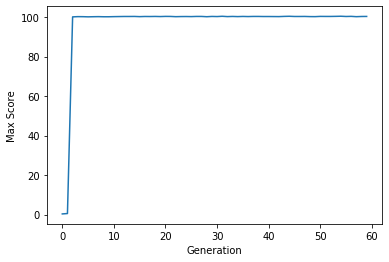

In [52]:
x = []
y = []
for i in range(num_gen):
    x.append(i)
for score in allScores:
    y.append(score[1])
plt.xlabel('Generation')
plt.ylabel('Max Score')
plt.plot(x, y)
plt.show()

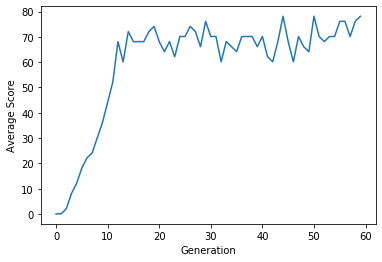

In [53]:
x = []
y = []
for i in range(num_gen):
    x.append(i)

for score in allScores:
    y.append(score[2])
plt.xlabel('Generation')
plt.ylabel('Average Score')
plt.plot(x, y)
plt.show()

### Diagnostics

In [54]:
# find all q values that correspond to given team
def find_team_q (q_table, team):
    result = []  
    for entry in q_table.q:
        if entry['team'] == str(team.id):
            result.append(entry)
    return result

# TODO better organize this for quicker analysis
def display_q (result):
    for entry in result:
        print(entry)

In [82]:
# run a given team after training
def post_training_run (q_table, team):
    env.reset()
    epsilon = 0.01 # where should I define this??
    l_t, a_t = evaluate(team, env.current_state, epsilon, q_table)
    states = []
    print(states)
    states.append(env.current_state)    
    t = 0
    t_max = 50
    total_reward = 0
    while t < t_max:
        print(states)
        s_next, reward, isDone = env.step(a_t)
        states.append(s_next)
        #print(reward)
        total_reward += reward
        if isDone:
            return states, total_reward
        l_next, a_next = evaluate(team, env.current_state, epsilon, q_table)
        a_t = a_next
        l_t = l_next
        t = t + 1
    return states, total_reward

# animate path (set for Downing fig 11, will have to adjust if animating another task)
def animate_path(sequence):
    current_map = np.zeros((5, 5))
    # add barrier
    current_map[(1, 2)] = 5
    current_map[(1, 3)] = 5
    current_map[(2, 2)] = 5
    current_map[(2, 3)] = 5

    # animate the run!
    for i in range(len(sequence)):
        time.sleep(0.5)
        if i == 0:
            current_map[sequence[i]] = 1
            clear_output(wait=True)
            print(0)
            print(current_map)
        else:
            current_map[sequence[i-1]] = 0
            current_map[sequence[i]] = 1
            clear_output(wait=True)
            print(i)
            print(current_map)

In [83]:
# run tests on champion
champ_table = find_team_q(table, champion)
display_q(champ_table)

{'team': '44669905-d1e0-43eb-b996-7df44434739d', 'learner': 'ffb78e9b-d8ca-4868-923e-7281a374eee0', 'action': 2, 'q': 0.005852710743776198}
{'team': '44669905-d1e0-43eb-b996-7df44434739d', 'learner': 'cbbc7ba4-7cbc-49e7-8cdc-ecadbbc9bb6a', 'action': 0, 'q': 0.002855401918827954}
{'team': '44669905-d1e0-43eb-b996-7df44434739d', 'learner': '0f14db36-2c5f-44ef-80d6-e8a3f8a2d7c7', 'action': 1, 'q': 0}
{'team': '44669905-d1e0-43eb-b996-7df44434739d', 'learner': 'a6fd9eb9-a556-48a6-9bc6-154ecb338704', 'action': 3, 'q': 0}
{'team': '44669905-d1e0-43eb-b996-7df44434739d', 'learner': '41e42f7c-96ea-429e-99ad-ae47d8bc4684', 'action': 2, 'q': 0}
{'team': '44669905-d1e0-43eb-b996-7df44434739d', 'learner': '1fc647ad-125a-4da9-b612-9916491a597d', 'action': 0, 'q': 0}
{'team': '44669905-d1e0-43eb-b996-7df44434739d', 'learner': '7ec6e824-08fe-4ba8-8b7b-c8fca33df7be', 'action': 2, 'q': 0}
{'team': '44669905-d1e0-43eb-b996-7df44434739d', 'learner': '176a8320-eaca-422c-bf1d-3bf7030580d8', 'action': 0, 'q

In [84]:
states, score = post_training_run(table, champion)
print(score)

[]
[(4, 0)]
[(4, 0), (4, 1)]
[(4, 0), (4, 1), (3, 1)]
[(4, 0), (4, 1), (3, 1), (3, 2)]
[(4, 0), (4, 1), (3, 1), (3, 2), (3, 1)]
[(4, 0), (4, 1), (3, 1), (3, 2), (3, 1), (3, 2)]
[(4, 0), (4, 1), (3, 1), (3, 2), (3, 1), (3, 2), (3, 2)]
[(4, 0), (4, 1), (3, 1), (3, 2), (3, 1), (3, 2), (3, 2), (3, 3)]
[(4, 0), (4, 1), (3, 1), (3, 2), (3, 1), (3, 2), (3, 2), (3, 3), (3, 3)]
[(4, 0), (4, 1), (3, 1), (3, 2), (3, 1), (3, 2), (3, 2), (3, 3), (3, 3), (3, 4)]
[(4, 0), (4, 1), (3, 1), (3, 2), (3, 1), (3, 2), (3, 2), (3, 3), (3, 3), (3, 4), (3, 3)]
[(4, 0), (4, 1), (3, 1), (3, 2), (3, 1), (3, 2), (3, 2), (3, 3), (3, 3), (3, 4), (3, 3), (3, 4)]
[(4, 0), (4, 1), (3, 1), (3, 2), (3, 1), (3, 2), (3, 2), (3, 3), (3, 3), (3, 4), (3, 3), (3, 4), (2, 4)]
[(4, 0), (4, 1), (3, 1), (3, 2), (3, 1), (3, 2), (3, 2), (3, 3), (3, 3), (3, 4), (3, 3), (3, 4), (2, 4), (2, 4)]
[(4, 0), (4, 1), (3, 1), (3, 2), (3, 1), (3, 2), (3, 2), (3, 3), (3, 3), (3, 4), (3, 3), (3, 4), (2, 4), (2, 4), (1, 4)]
[(4, 0), (4, 1), (3, 1

In [85]:
animate_path(states)

18
[[0. 0. 0. 0. 1.]
 [0. 0. 5. 5. 0.]
 [0. 0. 5. 5. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
